## *importing libraries*

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [141]:
from sklearn.cluster import KMeans
import folium # map rendering library


## *data collection and preparation*

In [3]:
# COLLECTING DATA FOR TORONTO CITY AREA
# WEB SCRAPING

site= "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(site).text
soup = BeautifulSoup(page,"html5lib")
tables = soup.find_all("table")
type(tables)

bs4.element.ResultSet

In [5]:
df_hood= pd.DataFrame(columns=['Postal Code','Borough','Neighborhood'])
row1=tables[0].tbody.find_all('td')
for col in row1:
    if ("Not assigned") not in col.text:
        ab=col.text
        code= ab[1:4]
        hood=ab.split('(')[1][:-3]
        hood=hood.replace('/',', ')
        borough=ab.split('(')[0][4:]
        df_hood=df_hood.append({'Postal Code':code,'Borough':borough,'Neighborhood':hood}, ignore_index=True)
df_hood.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park , Harbourfront"
3,M6A,North York,"Lawrence Manor , Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [8]:
# INSERTING THE LATIDUTED AND LONGITUDE
# FROM DOWNLOAD GEODATA FILE THEN MERGING TWO DATAFRAMES
geodata=pd.read_csv("Geospatial_Coordinates.csv")
df_hood =df_hood.join(geodata.set_index('Postal Code'),on='Postal Code')
df_hood.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor , Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [11]:
df_hood.shape

(103, 5)

In [9]:
# GETTING OUT ONLY TORONTO AREA OUT
listed=pd.DataFrame(columns=['name'])
for borough in df_hood['Borough']:
    if'Toronto'in borough:
        listed=listed.append({'name':borough},ignore_index=True)
    else:
        None 
listed
toronto_area=listed.name.unique()
toronto_area
df_toronto=pd.DataFrame(columns=df_hood.columns)
df_toronto=df_hood[df_hood.Borough.isin(toronto_area)].reset_index().drop(["index"],axis=1)
df_toronto.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306


#### getting more data from Four Square 

In [37]:
CLIENT_ID = 'F5KSGNKOZRAOFG4ZXMO1ZJPVN1IGALY0PR5HN0ZOYV345LQH' # your Foursquare ID
CLIENT_SECRET = 'SORNULU0JV3EQL5V4BRVZMNPKKLHYNPSCZYAN4N54H42PKQJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # i tried 150 for better segmentation though cap was set back to 100


In [276]:
 url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            43.654260, 
            -79.360636, 
            500, 
            LIMIT)
results = requests.get(url).json()["response"]['groups'][0]['items']
#results

In [39]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [40]:
toronto_venues=getNearbyVenues(df_toronto['Neighborhood'],df_toronto['Latitude'],df_toronto['Longitude'])
toronto_venues.shape

(1587, 7)

In [30]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park , Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


In [44]:
cat=toronto_venues['Venue Category'].unique()
all_resturants=[]
for v in cat:
    if "Restaurant" in v:
        all_resturants.append(v)
all_resturants.sort()
print(all_resturants)

['American Restaurant', 'Asian Restaurant', 'Belgian Restaurant', 'Brazilian Restaurant', 'Cajun / Creole Restaurant', 'Caribbean Restaurant', 'Chinese Restaurant', 'Colombian Restaurant', 'Comfort Food Restaurant', 'Cuban Restaurant', 'Doner Restaurant', 'Dumpling Restaurant', 'Eastern European Restaurant', 'Ethiopian Restaurant', 'Falafel Restaurant', 'Fast Food Restaurant', 'Filipino Restaurant', 'French Restaurant', 'German Restaurant', 'Gluten-free Restaurant', 'Greek Restaurant', 'Indian Restaurant', 'Italian Restaurant', 'Japanese Restaurant', 'Korean Restaurant', 'Latin American Restaurant', 'Mediterranean Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant', 'Modern European Restaurant', 'Molecular Gastronomy Restaurant', 'Moroccan Restaurant', 'New American Restaurant', 'Portuguese Restaurant', 'Ramen Restaurant', 'Restaurant', 'Seafood Restaurant', 'Sri Lankan Restaurant', 'Sushi Restaurant', 'Taiwanese Restaurant', 'Thai Restaurant', 'Theme Restaurant', 'Tibetan R

In [47]:
venue_hood_count= toronto_venues.groupby("Neighborhood").count().reset_index()
venue_hood_count.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,58,58,58,58,58,58
1,"Brockton , Parkdale Village , Exhibition Place",23,23,23,23,23,23
2,"CN Tower , King and Spadina , Railway Lands ...",15,15,15,15,15,15
3,Central Bay Street,60,60,60,60,60,60
4,Christie,16,16,16,16,16,16


#### creating a table of neighborhood by no. resturant count

In [88]:
restaurant_count=pd.DataFrame(columns=['Neighborhood','Restaurant_count'])
#resturant_count

for hood,ven in zip (toronto_venues['Neighborhood'],toronto_venues['Venue Category']):
    if ven in all_resturants:
        restaurant_count=restaurant_count.append({'Neighborhood':hood,'Restaurant_count':ven}, ignore_index=True)
restaurant_count=restaurant_count.groupby("Neighborhood").count().sort_values("Restaurant_count",ascending=False)
restaurant_count.reset_index()

restaurant_count.head()


,Restaurant_count
Neighborhood,
"Commerce Court , Victoria Hotel",30
"First Canadian Place , Underground city",30
Church and Wellesley,26
"Toronto Dominion Centre , Design Exchange",25
"Richmond , Adelaide , King",25


In [231]:
pc=df_merged
pc['Restaurant_count'].replace(np.NaN,0,inplace=True)
pc

,Neighborhood,Venue,Restaurant_count
0,Berczy Park,58,11.0
1,"Brockton , Parkdale Village , Exhibition Place",23,2.0
2,"CN Tower , King and Spadina , Railway Lands ...",15,0.0
3,Central Bay Street,60,15.0
4,Christie,16,2.0
5,Church and Wellesley,76,26.0
6,"Commerce Court , Victoria Hotel",100,30.0
7,Davisville,35,10.0
8,Davisville North,9,0.0
9,"Dufferin , Dovercourt Village",16,1.0


### DATA ANALYSIS: is there a correlation between no. venues and no. of restuarants. we will merge and plot to see

In [101]:
df_merged=venue_hood_count[['Neighborhood','Venue']]
df_merged=df_merged.join(restaurant_count,on='Neighborhood')
df_merged.head()


,Neighborhood,Venue,Restaurant_count
0,Berczy Park,58,11.0
1,"Brockton , Parkdale Village , Exhibition Place",23,2.0
2,"CN Tower , King and Spadina , Railway Lands ...",15,NaN
3,Central Bay Street,60,15.0
4,Christie,16,2.0


In [103]:
df_merged[["Venue","Restaurant_count"]].corr()

,Venue,Restaurant_count
Venue,1.000000,0.914032
Restaurant_count,0.914032,1.000000


<AxesSubplot:xlabel='Venue', ylabel='Restaurant_count'>

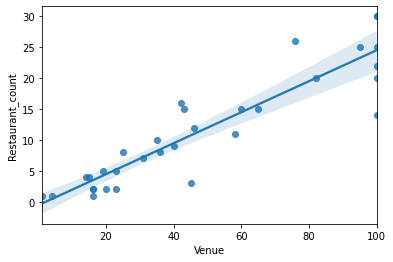

In [102]:
sns.regplot(x="Venue", y="Restaurant_count", data=df_merged)

#### with Correlation at 0.91 we can say except for the few out layers that we on to something
### lets saves this result on go on to use CLUSTERING to further analysis trends between Neighborhood Smilarities and Number of Restuarants

### finally because restaurant y is our independant variable lets remove all 45 of it

In [122]:
toronto_xvenues=toronto_venues[toronto_venues['Venue Category'].isin (toronto_venues['Venue Category'].replace(all_resturants,False))]#xvenues for venues other than restuarants

In [139]:
## turning categorical into numerical
df_cat=pd.get_dummies(toronto_xvenues[['Venue Category']],prefix="", prefix_sep="")
## adding neighborhood name back
df_cat['Neighborhood'] = toronto_xvenues['Neighborhood']
list(df_cat.columns).index('Neighborhood')
fixed_columns = ([df_cat.columns[126]] + list(df_cat.columns[:126]) + list(df_cat.columns[127:]))
df_cat = df_cat[fixed_columns]
df_cat.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,...,Tanning Salon,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Regent Park , Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



#### creating data for neighborhood venue pattern let consolidate and normalize data

In [140]:
df_hood_ratio=df_cat.groupby("Neighborhood").mean().reset_index()
df_hood_ratio.head()

,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,Art Gallery,...,Tanning Salon,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.021277,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton , Parkdale Village , Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,"CN Tower , King and Spadina , Railway Lands ...",0.0,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.022222
4,Christie,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


### imploring Machine learning Clustering tool kmeans, lets label_ this hoods

In [152]:
kclusters=6
df_hood_cluster=df_hood_ratio.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_hood_cluster)

# checking cluster labels generated for each row in the dataframe
len(kmeans.labels_)
kmeans.labels_

array([0, 5, 5, 0, 5, 0, 0, 5, 5, 5, 5, 0, 0, 2, 0, 0, 5, 5, 5, 4, 5, 0,
       0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 5, 5, 3, 0, 0, 5])

#### at k=5 this results suggests that 33 neighborhoods out of 38 are similar this is too open and vauge
### but at K=6 we get a slightly more diverse result

In [155]:
# lets fit label_s in
df_hood_ratio.insert(0, 'Cluster Labels',kmeans.labels_)
df_hood_ratio.head()

,Cluster Labels,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,...,Tanning Salon,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Wine Shop,Yoga Studio
0,0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,5,"Brockton , Parkdale Village , Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
2,5,"CN Tower , King and Spadina , Railway Lands ...",0.0,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,0,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.022222
4,5,Christie,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


In [272]:
def shorter(text):
    a=str(text)[:10]
    return a
xlabel2=df_labeled2['Neighborhood'].apply(shorter)
xlabel2=tuple(xlabel2.values)


#### lets insert our independent variable no. of resturant and check for any similar correlations 

Neighborhood by No. of restuarants and cluster label_


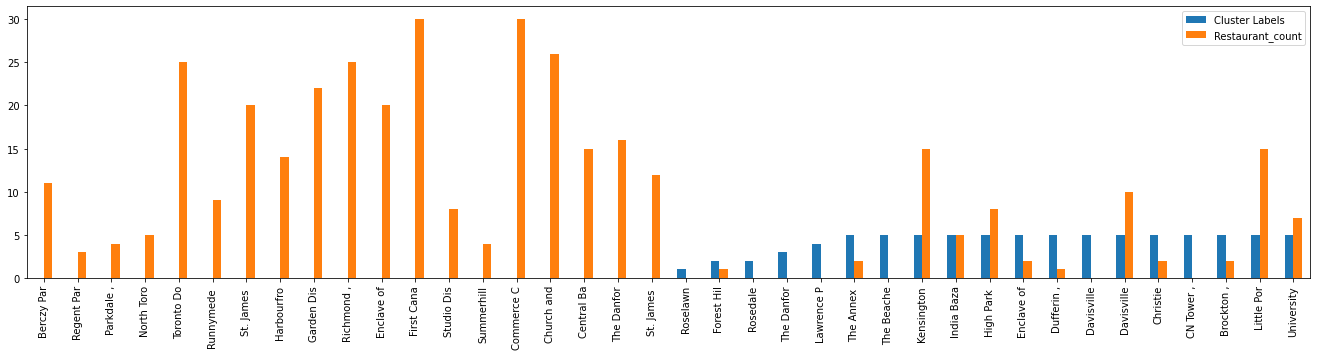

In [215]:
df_labeled=df_hood_ratio.join(restaurant_count,on='Neighborhood')
df_labeled= df_labeled[['Neighborhood','Cluster Labels','Restaurant_count']].sort_values('Cluster Labels').reset_index()
x=df_labeled.index
df_labeled[['Cluster Labels','Restaurant_count']].plot(kind='bar',figsize=(23,5))
plt.xticks(x,xlabel)
print("Neighborhood by No. of restuarants and cluster label_")

### some trend is appearing, now what if we factor total number on venues like we found earlier to our clustering algorithm combine both neighborhood venue smilarity and number total number of venues...  

## ultimately we can find that neigbhood out layer that need to have more restuarants to attain equilibrum too 

In [237]:
df_hood_rm=df_hood_ratio.join(df_merged[['Neighborhood','Venue']].set_index('Neighborhood'), on='Neighborhood')
df_hood_rm.head(1)

,Cluster Labels,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,Aquarium,...,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Wine Shop,Yoga Studio,Venue
0,0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58


In [238]:
kclusters=6
df_hood_cluster2=df_hood_rm.drop(['Neighborhood','Cluster Labels'], 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_hood_cluster2)

# checking cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 3, 3, 4, 3, 5, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 3, 3, 4, 2, 0, 3,
       3, 0, 1, 2, 2, 0, 5, 0, 0, 3, 3, 2, 2, 0, 1, 0])

In [239]:
df_hood_rm.insert(0, 'Cluster Labels2',kmeans.labels_)
df_hood_rm.head()

,Cluster Labels2,Cluster Labels,Neighborhood,Adult Boutique,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,Antique Shop,...,Tea Room,Theater,Toy / Game Store,Trail,Train Station,Video Game Store,Wine Bar,Wine Shop,Yoga Studio,Venue
0,4,0,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,58
1,3,5,"Brockton , Parkdale Village , Exhibition Place",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,23
2,3,5,"CN Tower , King and Spadina , Railway Lands ...",0.0,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,15
3,4,0,Central Bay Street,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.022222,0.0,0.0,0.0,0.0,0.0,0.022222,0.0,0.022222,60
4,3,5,Christie,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,16


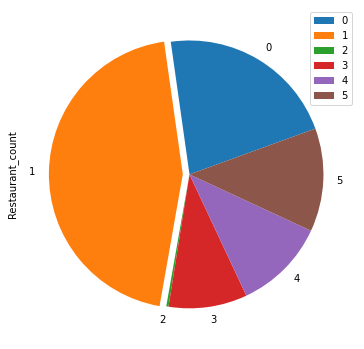

In [260]:
df_pie=df_labeled2[['Cluster Labels2','Restaurant_count']].groupby('Cluster Labels2').sum()
df_pie['Restaurant_count'].plot(kind='pie',figsize=(6,8),startangle=20,explode=[0,0.05,0,0,0,0],)
plt.legend(labels=df_pie.index)

### shows that cluster 1 stands out followed by cluster 0 as cluster with triving Resturant Business
## visualizing this result in another way, we can see the individual hoods in the cluster and resturant saturation

Neighborhood by No. of restuarants and 2ND cluster label_


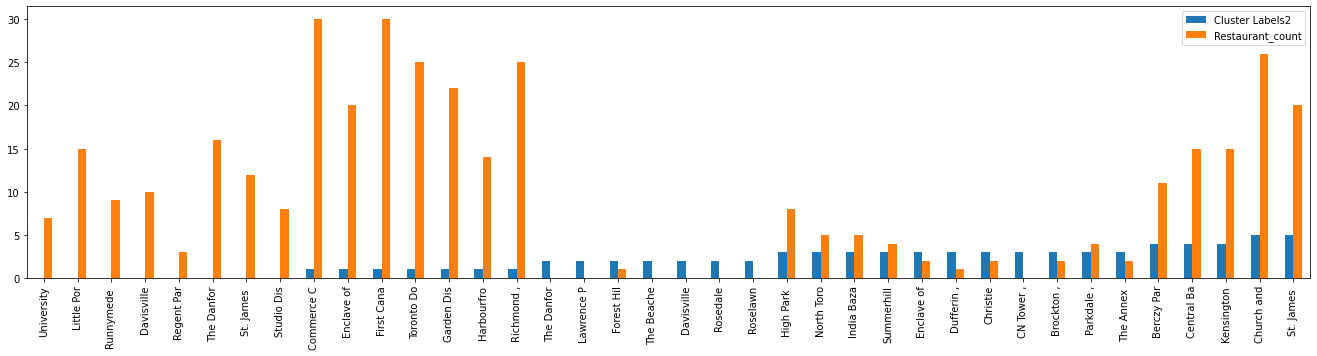

In [273]:
df_labeled2=df_hood_rm.join(restaurant_count,on='Neighborhood')
df_labeled2= df_labeled2[['Neighborhood','Cluster Labels2','Restaurant_count']].sort_values('Cluster Labels2').reset_index()
x=df_labeled2.index
df_labeled2[['Cluster Labels2','Restaurant_count']].plot(kind='bar',figsize=(23,5))
plt.xticks(x,xlabel2)
print("Neighborhood by No. of restuarants and 2ND cluster label_")

In [274]:
recommendatn=df_labeled2[['Neighborhood','Cluster Labels2','Restaurant_count']][df_labeled2['Cluster Labels2']==1].sort_values('Restaurant_count').reset_index()
recommendatn.head(3)

,index,Neighborhood,Cluster Labels2,Restaurant_count
0,13,"Harbourfront East , Union Station , Toronto ...",1,14.0
1,9,Enclave of M5E,1,20.0
2,12,"Garden District, Ryerson",1,22.0


## interpreting data we can see that Harbourfront East  and Enclave of M5E neighborhoods are the most promising because they are not yet saturated with a many restuarants yet and a have the atributes of all the places with teaming Restuarants

In [287]:
toronto_merged=df_toronto
toronto_merged=toronto_merged.join(df_hood_rm.set_index("Neighborhood"),on= "Neighborhood")
toronto_merged['Cluster Labels2']=toronto_merged['Cluster Labels2'].replace(np.NAN,0).astype(int)


In [291]:
latitude= toronto_merged['Latitude'].mean()
longitude= toronto_merged['Longitude'].mean()
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

In [292]:

# set color scheme for the clusters
colors=['red','blue','yellow','purple','green','orange']

# add markers to the map
for lat, lon, pop, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels2']):
    label = folium.Popup(str(pop) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[int(cluster)],
        fill=True,
        fill_color=colors[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters